In [1]:
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the Dataset
We will use librosa to extract audio features (e.g., MFCCs) and pandas to handle the CSV labels.

In [2]:
# Path to the audio folder and label CSV
audio_folder = '../dataset_normalized'
labels_csv = 'audio_durations_labels.csv'

# Load the labels
labels_df = pd.read_csv(labels_csv)

# Function to extract audio features (MFCCs) from the audio file
def extract_mfcc(file_path, n_mfcc=13, max_len=400):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Padding or truncating the MFCCs to ensure uniform length
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
        
    return mfcc.T  # Transpose to have shape (max_len, n_mfcc)

# Create lists to store features and labels
features = []
labels = []

# Map string labels to integers
label_map = {'short': 0, 'medium': 1, 'long': 2}

# Load and preprocess each audio file
for i, row in labels_df.iterrows():
    file_name = row['file_name']
    label = row['label']
    
    # Construct the full path to the audio file
    file_path = f"{audio_folder}/{file_name}"
    
    # Extract features
    mfcc_features = extract_mfcc(file_path)
    
    # Append features and corresponding label
    features.append(mfcc_features)
    labels.append(label_map[label])

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Define the RNN Model in TensorFlow
We'll define the RNN model using LSTM layers in TensorFlow. The shape of the input data will be (max_len, n_mfcc).

In [3]:

# Define the max_len and input_size
max_len = 400  # This is the number of timesteps (the length of your MFCCs)
input_size = 13  # Number of MFCC coefficients (features per timestep)

# Define the number of hidden units in the LSTM
hidden_size = 64  # This can be tuned

# Number of output classes (short, medium, long)
num_classes = 3

# Define the RNN model using the updated argument 'shape' instead of 'input_shape'
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(max_len, input_size)),  # Updated 'input_shape' to 'shape'
    tf.keras.layers.LSTM(hidden_size, return_sequences=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,163 (78.76 KB)

 Trainable params: 20,163 (78.76 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model
Train the model on the training dataset (X_train, y_train) for a few epochs.

In [4]:
# Train the model
epochs = 10
batch_size = 16

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2386 - loss: 1.3132 - val_accuracy: 0.6541 - val_loss: 0.9429
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6715 - loss: 0.9111 - val_accuracy: 0.7676 - val_loss: 0.8213
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7304 - loss: 0.7856 - val_accuracy: 0.7784 - val_loss: 0.7367
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7473 - loss: 0.6999 - val_accuracy: 0.7838 - val_loss: 0.6685
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7725 - loss: 0.6051 - val_accuracy: 0.7838 - val_loss: 0.6067
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7707 - loss: 0.6059 - val_accuracy: 0.7892 - val_loss: 0.5717
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8214 - loss: 0.5285 - val_accuracy: 0.8108 - val_loss: 0.5440
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8400 - loss: 0.4967 - val_accuracy: 0.8270 - v

# Confusion Matrix and Classification Report

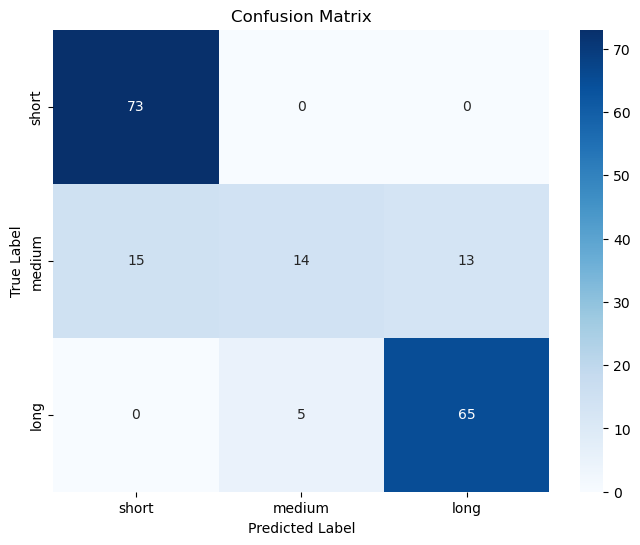

Classification Report:

              precision    recall  f1-score   support

       short       0.83      1.00      0.91        73
      medium       0.74      0.33      0.46        42
        long       0.83      0.93      0.88        70

    accuracy                           0.82       185
   macro avg       0.80      0.75      0.75       185
weighted avg       0.81      0.82      0.79       185



In [6]:
# No need to apply argmax if y_test is already in label form
y_true = y_test  # Assuming y_test contains class labels (0, 1, 2)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))


## Save the Model
Once the model is trained, we saved it in TensorFlow's SavedModel format so it can be converted to TensorFlow.js.

In [12]:
# Save the model in TensorFlow SavedModel format (directory-based)
model.export("rnn_model_tf")

INFO:tensorflow:Assets written to: rnn_model_tf/assets


INFO:tensorflow:Assets written to: rnn_model_tf/assets


Saved artifact at 'rnn_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 400, 13), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13762444128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13762444480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13762442368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13762443424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13762439904: TensorSpec(shape=(), dtype=tf.resource, name=None)
